<a href="https://colab.research.google.com/github/2024S-Ajou-ML-pandastic4/whaccent/blob/master/AST_finetuning_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!add-apt-repository -y ppa:jonathonf/ffmpeg-4
!apt update
!apt install -y ffmpeg

!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
#!pip install jiwer
#!pip install gradio
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

Repository: 'deb https://ppa.launchpadcontent.net/jonathonf/ffmpeg-4/ubuntu/ jammy main'
Description:
Backport of FFmpeg 4 and associated libraries. Now includes AOM/AV1 support!

FDK AAC is not compatible with GPL and FFmpeg can't be redistributed with it included. Please don't ask for it to be added to this public PPA.

---

PPA supporters:

BigBlueButton (https://bigbluebutton.org)

---

Donate to FFMPEG: https://ffmpeg.org/donations.html
Donate to Debian: https://www.debian.org/donations
Donate to this PPA: https://ko-fi.com/jonathonf
More info: https://launchpad.net/~jonathonf/+archive/ubuntu/ffmpeg-4
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding key to /etc/apt/trusted.gpg.d/jonathonf-ubuntu-ffmpeg-4.gpg with fingerprint 4AB0F789CBA31744CC7DA76A8CF63AD3F06FC659
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubun

# hugging face loging

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# prepare data from Hugging face (iisking/waccent)
- No Korean accent data added yet -> solved
- But going to pre-process it and put it in soon -> solved
- duration has to be 4~6 sec -> solved

In [ ]:
# Select CUDA device index
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_name_or_path = "MIT/ast-finetuned-audioset-10-10-0.4593"
language = "English"
language_abbr = "en"
task = "classification"
dataset_name = "iisking/waccent"
#batch_size = 32

In [ ]:
from datasets import load_dataset, DatasetDict

dataset = DatasetDict()

dataset["train"] = load_dataset(dataset_name, split="train")
dataset["validation"] = load_dataset(dataset_name, split="validatoin")
dataset["test"] = load_dataset(dataset_name, split="test")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating validatoin split:   0%|          | 0/3618 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1782 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 12600
    })
    validation: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 3618
    })
    test: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 1782
    })
})


# (OPTIONAL)Convert to TOY dataset which is 10% of original dataset

In [ ]:
"""def sample_dataset(dataset, fraction=0.2):
    return dataset.train_test_split(test_size=fraction, seed=42)['test']

dataset = DatasetDict({
    'train': sample_dataset(dataset['train'], 0.1),
    'validation': sample_dataset(dataset['validation'], 0.1),
    'test': sample_dataset(dataset['test'], 0.1)
})

print(dataset)"""

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 362
    })
    test: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 179
    })
})


# Preprocessing Data for input of AST

## Resampling to 16,000

In [ ]:
dataset["train"][0]

{'filename': {'path': 'sample-039367.mp3',
  'array': array([ 0.00000000e+00, -5.69671744e-16, -1.50118273e-16, ...,
          4.39018113e-05,  1.65740057e-05, -2.00537470e-05]),
  'sampling_rate': 48000},
 'text': 'if we serve tea in crystal the shop is going to expand',
 'accent': 'england',
 'duration': 3.984,
 '__index_level_0__': 11173}

In [ ]:
from datasets import Audio
dataset = dataset.cast_column("filename", Audio(sampling_rate=16000))

In [ ]:
dataset["train"][0]

{'filename': {'path': 'sample-039367.mp3',
  'array': array([3.63797881e-11, 5.09317033e-11, 7.27595761e-11, ...,
         2.71822646e-05, 2.35640764e-05, 8.86527414e-06]),
  'sampling_rate': 16000},
 'text': 'if we serve tea in crystal the shop is going to expand',
 'accent': 'england',
 'duration': 3.984,
 '__index_level_0__': 11173}

In [ ]:
train_accent_list = list(set(dataset["train"]['accent']))
valid_accent_list = list(set(dataset["validation"]["accent"]))
test_accent_list = list(set(dataset["test"]["accent"]))


print(f'train_accent_list : {train_accent_list}')
print(f'valid_accent_list : {valid_accent_list}')
print(f'test_accent_list  : {test_accent_list}')

train_accent_list : ['australia', 'us', 'england', 'canada', 'indian', 'KR']
valid_accent_list : ['australia', 'us', 'england', 'canada', 'indian', 'KR']
test_accent_list  : ['australia', 'us', 'england', 'canada', 'indian', 'KR']


label2id, id2label

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(train_accent_list):
    label2id[label] = i
    id2label[i] = label

label2id, id2label

({'australia': 0, 'us': 1, 'england': 2, 'canada': 3, 'indian': 4, 'KR': 5},
 {0: 'australia', 1: 'us', 2: 'england', 3: 'canada', 4: 'indian', 5: 'KR'})

pocessing Dataset using feature extractor

In [ ]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

ASTFeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "ASTFeatureExtractor",
  "feature_size": 1,
  "max_length": 1024,
  "mean": -4.2677393,
  "num_mel_bins": 128,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000,
  "std": 4.5689974
}

above setting max_length to 512 occurs error on ASTEmbedding forward :- > DO NOT NEED since AST has padding option, and it does ignore the padding values

### Checking approximate duration(length), audio and length
- execute several times for check generativity

### Processing dataset

In [ ]:
import torch
from datasets import ClassLabel
ClassLabels = ClassLabel(num_classes=len(train_accent_list), names=train_accent_list)
def preprocess_dataset(batch):
    # input_feature : audio file to spectrogram
    audio = batch["filename"]
    batch["input_values"] = feature_extractor(
        audio["array"],
        #max_length=int(feature_extractor.sampling_rate * max_duration),
        return_tensors="pt",
        truncation=True, # cut data which over the max_length
        padding="max_length", # padding data with
        sampling_rate=audio["sampling_rate"]).input_values.squeeze(0)


    # label : str to torch.long

    #batch['labels'] = torch.tensor(int(label2id[batch["accent"]]), dtype=torch.long)
    batch['labels'] = ClassLabels.str2int(batch['accent'])
    # batch['labels'] = batch['accent']
    return batch

processed_dataset = dataset.map(preprocess_dataset, remove_columns=dataset.column_names["train"],num_proc=1)
processed_dataset = processed_dataset.cast_column('labels', ClassLabels)

Map:   0%|          | 0/12600 [00:00<?, ? examples/s]

Map:   0%|          | 0/3618 [00:00<?, ? examples/s]

Map:   0%|          | 0/1782 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3618 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1782 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 12600
    })
    validation: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 3618
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 1782
    })
})

This `feature_extractor` is configured to return a tensor, but if it goes through the `map` function, it will return a list.

so, we need additional code (or datacollator) for changing dtyes from `list` to `tensor`

## Define a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union
#from transformers import BatchFeature

@dataclass
class DataCollatorWithPaddingForAST:
    feature_extractor: ASTFeatureExtractor

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_values = [{"input_values": feature["input_values"]} for feature in features]
        batch = self.feature_extractor.pad(input_values, return_tensors="pt")

        if "labels" in features[0]:

            labels = [feature["labels"] for feature in features]
            batch["labels"] = torch.tensor(labels, dtype=torch.long)

        return batch

data_collator = DataCollatorWithPaddingForAST(feature_extractor= feature_extractor)

## Evaluation Metrics

1. accuracy

In [ ]:
"""from datasets import load_metric
metric = load_metric("accuracy")

import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)"""

2. roc curve

In [ ]:
import numpy as np
from typing import Dict, List
# TODO:

import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr')

    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']

    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

# Get pre-trained AST model

In [ ]:
from transformers import ASTForAudioClassification, TrainingArguments, Trainer, ASTConfig
model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    #num_labels=len(train_accent_list)
)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

what we gonna do is to add additional `nn.Linear(572, num_labels)` after classifer

In [ ]:
import torch.nn as nn


classifier = model.classifier

new_linear = nn.Linear(in_features=classifier.dense.out_features, out_features=6)

new_classifier = nn.Sequential(classifier.dense, new_linear)

model.classifier = new_classifier

In [ ]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

## apply id2label and label2id on config

In [ ]:
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
model.config

ASTConfig {
  "_name_or_path": "MIT/ast-finetuned-audioset-10-10-0.4593",
  "architectures": [
    "ASTForAudioClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "australia",
    "1": "us",
    "2": "england",
    "3": "canada",
    "4": "indian",
    "5": "KR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "KR": 5,
    "australia": 0,
    "canada": 3,
    "england": 2,
    "indian": 4,
    "us": 1
  },
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "torch_dtype": "float32",
  "transformers_version": "4.42.0.dev0"
}

In [ ]:
model.num_labels = len(train_accent_list) #6

# Training

In [ ]:
batch_size=16
warmup_steps=50
weight_decay=0.02
num_train_epochs=10
model_name = "english_accents_classification"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-6, # 3e-5
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    fp16=True,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=1, # save fewer checkpoints to limit used space
    #report_to="mlflow",  # log to mlflow
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1483: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset = processed_dataset["train"],
    eval_dataset = processed_dataset["validation"],
    data_collator= data_collator,
    tokenizer= feature_extractor,
    compute_metrics= compute_metrics,
)

In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,1.104700,1.011272,0.869958,0.596186
2,1.315200,0.895488,0.899184,0.647872
3,0.455600,0.784348,0.920122,0.704533
4,0.365400,0.741362,0.931081,0.722499
5,0.513700,0.725298,0.937353,0.739635
6,0.117800,0.682335,0.942432,0.755113
7,0.409300,0.659235,0.946162,0.766169
8,0.528500,0.668817,0.947417,0.762300
9,0.573100,0.662771,0.948330,0.765064
10,0.284100,0.659261,0.949022,0.769486


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decod

TrainOutput(global_step=15750, training_loss=0.632866397014686, metrics={'train_runtime': 17099.6937, 'train_samples_per_second': 7.369, 'train_steps_per_second': 0.921, 'total_flos': 8.58080482689024e+18, 'train_loss': 0.632866397014686, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6592350602149963,
 'eval_roc_auc': 0.9461620758305606,
 'eval_accuracy': 0.7661691542288557,
 'eval_runtime': 289.8653,
 'eval_samples_per_second': 12.482,
 'eval_steps_per_second': 1.563,
 'epoch': 10.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(processed_dataset["test"])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.6688107848167419, 'test_roc_auc': 0.9440549715790736, 'test_accuracy': 0.754769921436588, 'test_runtime': 143.1572, 'test_samples_per_second': 12.448, 'test_steps_per_second': 1.558}


Accuracy: 0.7548
F1 Score: 0.7552


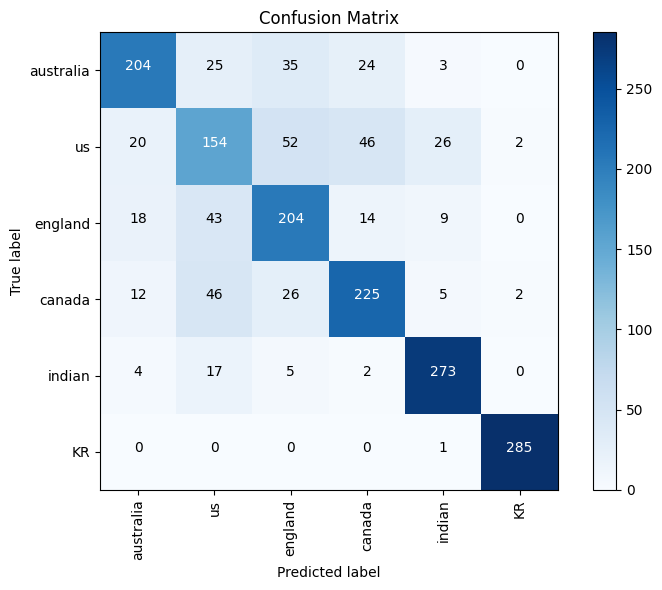


Classification report:

              precision    recall  f1-score   support

   australia     0.7907    0.7010    0.7432       291
          us     0.5404    0.5133    0.5265       300
     england     0.6335    0.7083    0.6689       288
      canada     0.7235    0.7120    0.7177       316
      indian     0.8612    0.9070    0.8835       301
          KR     0.9862    0.9965    0.9913       286

    accuracy                         0.7548      1782
   macro avg     0.7559    0.7564    0.7552      1782
weighted avg     0.7545    0.7548    0.7537      1782



In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)


# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)


    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(train_accent_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, train_accent_list, figsize=(8, 6), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=train_accent_list, digits=4))